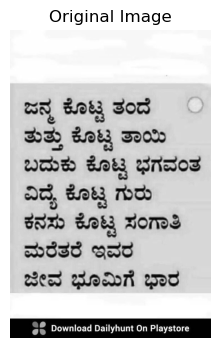

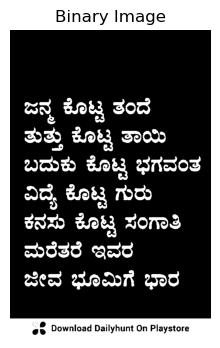

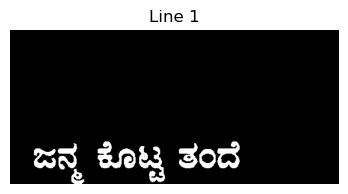

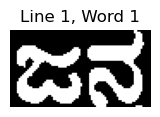

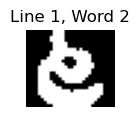

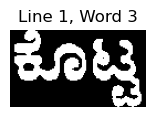

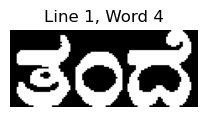

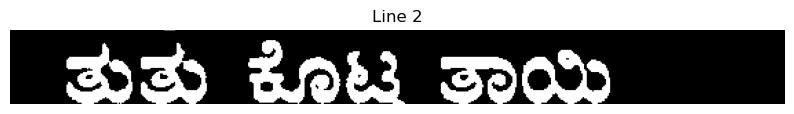

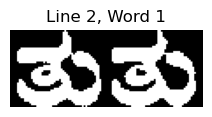

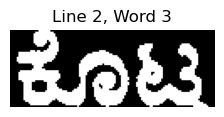

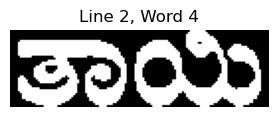

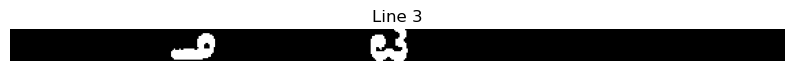

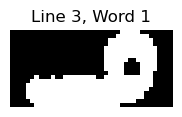

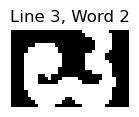

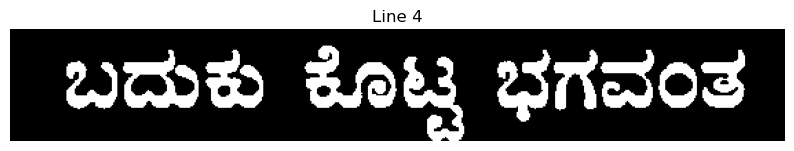

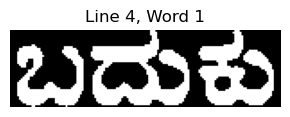

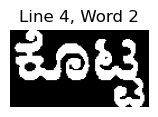

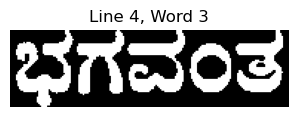

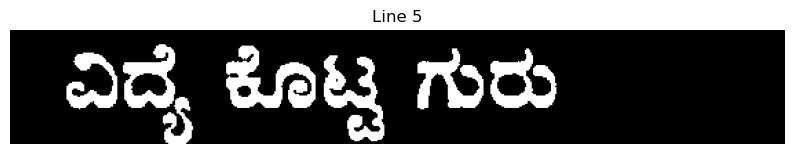

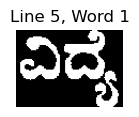

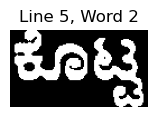

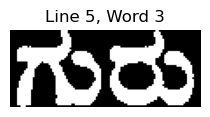

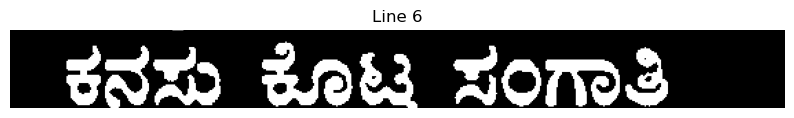

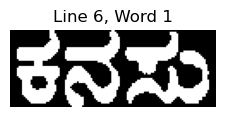

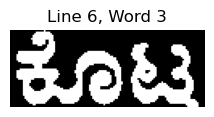

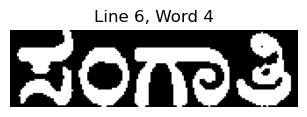

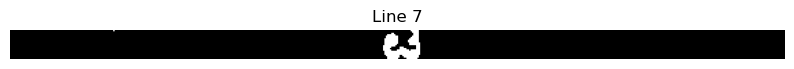

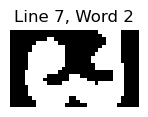

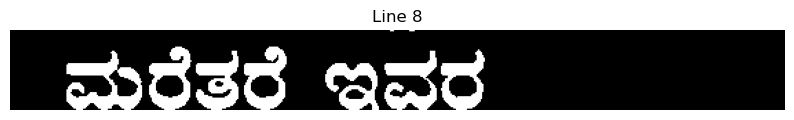

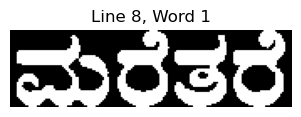

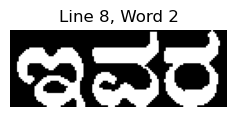

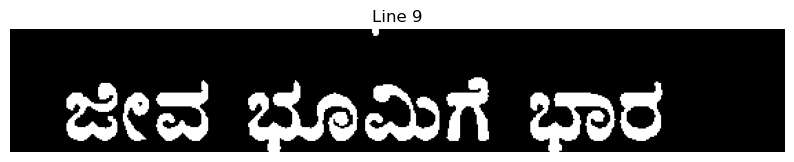

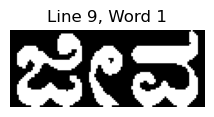

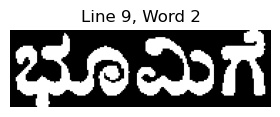

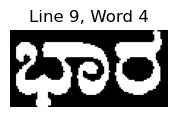

ConnectionError: HTTPSConnectionPool(host='translation-api.example.com', port=443): Max retries exceeded with url: /translate?text=janma&target=kn (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000023521651B90>: Failed to resolve 'translation-api.example.com' ([Errno 11001] getaddrinfo failed)"))

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests

# Function to check if the text contains Kannada characters
def is_kannada(text):
    return any('\u0C80' <= char <= '\u0CFF' for char in text)

# Function to translate text from English to Kannada
def translate_text(text):
    response = requests.get(f'https://translation-api.example.com/translate?text={text}&target=kn')
    if response.status_code == 200:
        return response.json().get('translatedText', '')
    return ''

# Function to highlight the word in the original image
def highlight_word(original_image, word_image):
    original_image_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    result = cv2.matchTemplate(original_image_gray, word_image, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    top_left = max_loc
    h, w = word_image.shape
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(original_image, top_left, bottom_right, (0, 255, 0), 2)

    # Fill the text with color
    cv2.putText(original_image, ' ', (top_left[0], top_left[1] + h), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    plt.figure(figsize=(10, 4))
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Highlighted Word')
    plt.axis('off')
    plt.show()

# Load the document image (this is the uploaded file path)
image_path = 'kan seg sample.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    print(f"Error: Unable to load the image at {image_path}")
else:
    # Display the original image
    plt.figure(figsize=(10, 4))
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    # Binarization using Otsu's thresholding
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Display the binary image
    plt.figure(figsize=(10, 4))
    plt.imshow(binary_image, cmap='gray')
    plt.title('Binary Image')
    plt.axis('off')
    plt.show()

    # Line Segmentation: Sum the pixel values along the horizontal axis (projection profile)
    horizontal_projection = np.sum(binary_image, axis=1)

    # Find the lines by detecting valleys in the projection profile
    line_threshold = np.mean(horizontal_projection) * 0.1
    line_boundaries = np.where(horizontal_projection < line_threshold)[0]

    # Segmentation: Extract individual lines
    lines = []
    start_idx = 0
    for i in range(1, len(line_boundaries)):
        if line_boundaries[i] - line_boundaries[i - 1] > 1:
            end_idx = line_boundaries[i]
            line_image = binary_image[start_idx:end_idx, :]
            lines.append(line_image)
            start_idx = end_idx

    # Display segmented lines using matplotlib
    for i, line in enumerate(lines):
        plt.figure(figsize=(10, 2))  # Set the figure size for each line
        plt.imshow(line, cmap='gray')
        plt.title(f'Line {i + 1}')
        plt.axis('off')
        plt.show()

        # Word Segmentation within each line using morphological operations
        kernel = np.ones((1, 5), np.uint8)  # Adjust the kernel size as needed
        dilated_line = cv2.dilate(line, kernel, iterations=2)  # Increase iterations if needed

        # Find contours of the words
        contours, _ = cv2.findContours(dilated_line, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Sort contours from left to right
        contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

        # Extract and display words
        for k, contour in enumerate(contours):
            x, y, w, h = cv2.boundingRect(contour)
            # Filter out small contours that might be noise
            if w > 5 and h > 5:  # Adjust these values based on your text size
                word_image = line[y:y+h, x:x+w]
                plt.figure(figsize=(5, 1))  # Set the figure size for each word
                plt.imshow(word_image, cmap='gray')
                plt.title(f'Line {i + 1}, Word {k + 1}')
                plt.axis('off')
                plt.show()

                # Save the word image for template matching
                cv2.imwrite(f'word_{i}_{k}.png', word_image)

# Real-time translation and search loop
while True:
    user_input = input("Enter word in English or Kannada: ").strip()
    if user_input == "exit":
        break
    if is_kannada(user_input):
        search_word = user_input
    else:
        search_word = translate_text(user_input)

    # Load the original image in color for highlighting
    original_image_color = cv2.imread(image_path)

    # Perform template matching and highlight the word
    highlight_word(original_image_color, cv2.imread(f'word_0_0.png', cv2.IMREAD_GRAYSCALE))